# HOMEWORK 04

**Submitted by: Diego Sol**

CSCE 636-600: Deep Learning

Professor: Dr. Anxiao Jiang

## Task 1

**Check out the Jupyter notebook for Chapter 7 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter07_working-with-keras.ipynb . Answer the questions: (1) What is the advantage of using  Sequential Models? (2) What is the advantage of using Functional API? (3) What is the advantage of using Subclassing? (5 points)**

###Advantages of using Sequential Models:
- it is simplest and easiest model to use
- many problems are readily solved without having to define any methods or classes
- it automatically matches input and ouptut sizes between layers
- the `summary()` method can be used to depict an easily interpretable summary of the model

###Advantages of using Functional API:
- it provides more control over the model than when using a Sequential Model
- unlike Sequential Models, it can be used to create layers with multiple inputs and outputs
- it represents a good midpoint between usability and flexibility
- the `plot_model()` method can be used to draw a plot that depicts the inputs and outputs to all the layers in the model

###Advantages of using Subclassing:
- of all the listed model-developing options, this one provides that highest degree control and accessibility
- it allows for user-defined metrics such as loss
- the new class automatically inherits methods and variables from the `keras.model` class
- it allows for precise customization of steps throughout the training process

## Task 2

**For the MNIST Dataset (for handwritten digit recognition), in the past, we built a one-input-one-output model, where the input is an image, and the output is a length-10 vector that represents a probability vector for the 10 classes (from class 0 to class 9). Today, let's build a one-input-multiple-output model, which has 10 outputs y_0, y_1, y_2, ..., y_9, where each y_i (for i between 0 and 9) is a real number between 0 and 1 that represents the probability for the input image to belong to class i. (That is, the probability that the input image does not belong to class i is 1 - y_i.) In other words, this new model is a combination of 10 binary classifiers (that is, one binary classifier for each class). The loss function for each y_i is the binary cross-entropy function, and the overall loss for the model is the summation of the 10 binary cross-entropies.**

**Let's define a new performance metric "aggregateAccuracy" as follows. First, we pick y_i\* to be the maximum value among y_0, y_1, y_2, ..., y_9. Then, we let i\* be the label that our model predicts for the input image. Then, "aggregateAccuracy" is simply the "accuracy" that we usually talk about: it is the fraction of images whose predicted label equals the true label.**

**Now compile your model and train it (with the loss function and performance metric defined above), and test the trained model's performance on the testing data.** 

**What you need to submit: (1) the complete code; (2) the training performance for training data and validation data (for both loss and aggregationAccuracy) shown in figures, where the x-axis is the number of epochs, and the y-axis is the loss or aggregateAccuracy; (3) show the test performance (loss and aggregateAccuracy) as two numbers. (15 points)**

Import packages and load MNIST data

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# load data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# prepare image data (reshape and normalize)
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

# prepare label data to meet task requirements
train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

Write a new performance metric

In [41]:
class aggregateAccuracy(keras.metrics.Metric):
    def __init__(self, name="aggAcc", **kwargs):
        super().__init__(name=name, **kwargs)
        self.y_i = np.argmax()


Create a single-input multiple-output network by using the Functional API

In [60]:
# input size
image_shape = train_images.shape[1]

# network with single input and multiple outputs
inputs = keras.Input(shape=(image_shape,), name="input")

layer_1 = layers.Dense(64, activation="relu", name="layer_1")(inputs)
layer_2 = layers.Dense(64, activation="relu", name="layer_2")(layer_1)

output0 = layers.Dense(1, activation="sigmoid", name="output0")(layer_2)
output1 = layers.Dense(1, activation="sigmoid", name="output1")(layer_2)
output2 = layers.Dense(1, activation="sigmoid", name="output2")(layer_2)
output3 = layers.Dense(1, activation="sigmoid", name="output3")(layer_2)
output4 = layers.Dense(1, activation="sigmoid", name="output4")(layer_2)
output5 = layers.Dense(1, activation="sigmoid", name="output5")(layer_2)
output6 = layers.Dense(1, activation="sigmoid", name="output6")(layer_2)
output7 = layers.Dense(1, activation="sigmoid", name="output7")(layer_2)
output8 = layers.Dense(1, activation="sigmoid", name="output8")(layer_2)
output9 = layers.Dense(1, activation="sigmoid", name="output9")(layer_2)

outputs = [output0,output1,output2,output3,output4,output5,output6,output7,output8,output9]
model = keras.Model(inputs=inputs, outputs=outputs)#[output0,output1,output2,output3,output4,output5,output6,output7,output8,output9])

# compilation
model.compile(optimizer="rmsprop",
              loss=["binary_crossentropy"],
              metrics=["accuracy"])

# # train the model
# history = model.fit(train_images, train_labels,
#                     epochs=1,
#                     batch_size=128,
#                     validation_split=0.4)

# # evaluate the model
# results = model.predict(test_images)

In [58]:
results[0]

array([6.9119560e-06, 7.3511916e-07, 7.2428934e-06, 1.0745190e-04,
       2.5071037e-07, 4.3486530e-06, 5.0141380e-09, 9.9986219e-01,
       2.0467664e-06, 8.8436545e-06], dtype=float32)

In [62]:
model.summary()
keras.utils.plot_model(model)

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 layer_1 (Dense)                (None, 64)           50240       ['input[0][0]']                  
                                                                                                  
 layer_2 (Dense)                (None, 64)           4160        ['layer_1[0][0]']                
                                                                                                  
 output0 (Dense)                (None, 1)            65          ['layer_2[0][0]']                
                                                                                           

In [32]:
# history data
history_dict = history.history

# training metric history
train_loss_values = history_dict["loss"]
train_acc_values = history_dict["accuracy"]

# validation metric history
val_loss_values = history_dict["val_loss"]
val_acc_values = history_dict["val_accuracy"]

# epochs
epochs = range(1, len(train_loss_values) + 1)

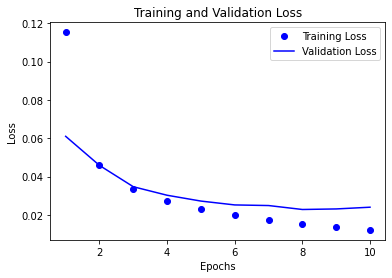

In [35]:
# create figure for training data
fig1, ax1 = plt.subplots()

# plot
ax1.plot(epochs, train_loss_values, "bo", label="Training Loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation Loss")
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
plt.show()

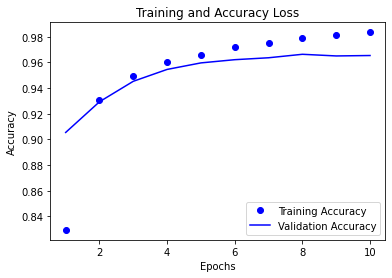

In [36]:
# create figure for training data
fig2, ax2 = plt.subplots()

# plot
ax2.plot(epochs, train_acc_values, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc_values, "b", label="Validation Accuracy")
ax2.set_title("Training and Accuracy Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()